In [2]:
#เตรียมการ library
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 30
print(cv2.__version__)

3.3.0


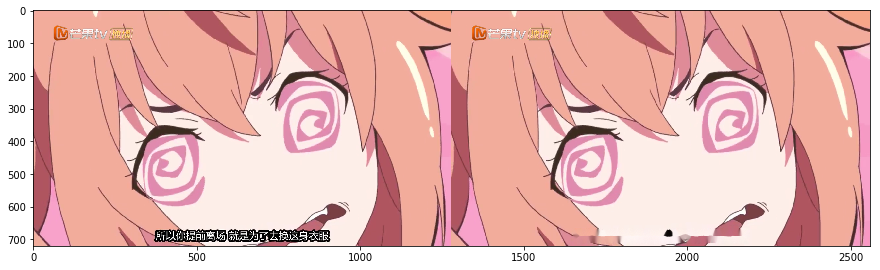

In [3]:
#โหลดรูปภาพต้นฉบับ
original_image = cv2.imread("images/ep01_0401.png")
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB) # cv2 use bgr but plt use rgb
plt.imshow(original_image)
plt.show()

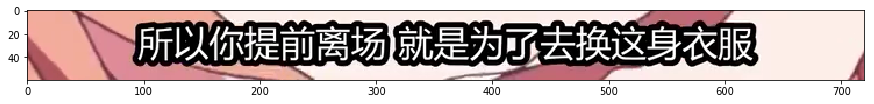

In [32]:
left = 280
right = 1000
up = 660
down = 720
subtitle_frame = original_image[up:down,left:right]
plt.imshow(subtitle_frame)
plt.show()

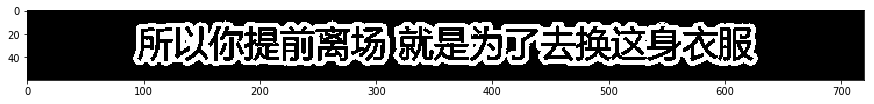

In [33]:
black_mask = cv2.inRange(subtitle_frame, (0,0,0), (30,30,30))
plt.imshow(black_mask,cmap = plt.cm.gray)
plt.show()

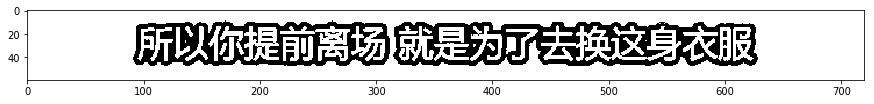

In [34]:
#สลับสีเพื่อเตรียมการเคลียของทิ้ง
inverted_mask = cv2.bitwise_not(black_mask)
plt.imshow(inverted_mask,cmap = plt.cm.gray)
plt.show()

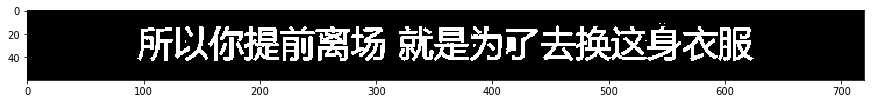

In [35]:
#ทำการถมดำ
cavity_mask = inverted_mask.copy()
height,width = inverted_mask.shape
mask_flood = np.zeros((height+2, width+2), np.uint8) #require by OpenCV spec but doesn't not affact
for y in range(0,height):
    cv2.floodFill(cavity_mask,mask_flood,(0,y),0)
    cv2.floodFill(cavity_mask,mask_flood,(width-1,y),0)
for x in range(0,width):
    cv2.floodFill(cavity_mask,mask_flood,(x,0),0)
    cv2.floodFill(cavity_mask,mask_flood,(x,height-1),0)
plt.imshow(cavity_mask,cmap = plt.cm.gray)
plt.show()

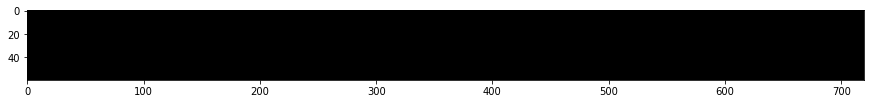

In [45]:
#หาพื้นที่ใหญ่เกินไปในภาพ
large_object = cv2.erode(cavity_mask,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9)))
plt.imshow(large_object,cmap = plt.cm.gray)
plt.show()

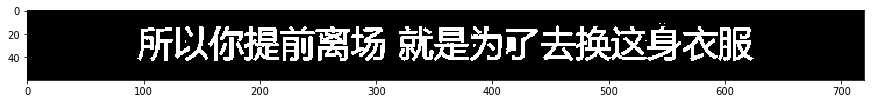

In [37]:
#ถมวัตถุที่ใหญ่เกินไป
mask_flood_object = np.zeros((height+2, width+2), np.uint8) 
mask_flood_canvas = np.zeros((height+2, width+2), np.uint8) 
large_object_canvas = large_object.copy()
cavity_with_noise = cavity_mask.copy()
for y in range(0,height):
    for x in range(0,width):
        if large_object_canvas[y][x] == 255:
            cv2.floodFill(large_object_canvas,mask_flood_object,(x,y),0)
            cv2.floodFill(cavity_with_noise,mask_flood_canvas,(x,y),0)
plt.imshow(cavity_with_noise,cmap = plt.cm.gray)
plt.show()

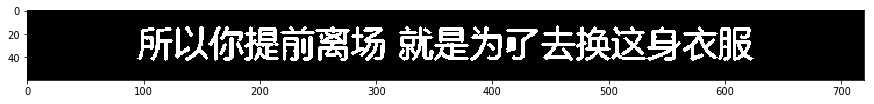

In [38]:
#ลบพื้นที่เล็กเกินไปออกจากภาพ
cavity_no_noise = cv2.morphologyEx(cavity_with_noise, cv2.MORPH_OPEN,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)))
plt.imshow(cavity_no_noise,cmap = plt.cm.gray)
plt.show()

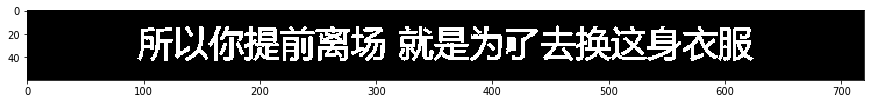

In [39]:
#ใช้ connected component labeling เพื่อเอาส่วนที่ต้องการโดยไม่ให้ตัวอักษรเสียหายมากนัก
nonoise = cavity_no_noise.copy()
noisy = cavity_with_noise.copy()
mask_flood_nonoise = np.zeros((height+2, width+2), np.uint8) 
mask_flood_noisy = np.zeros((height+2, width+2), np.uint8) 
for y in range(0,height):
    for x in range(0,width):
        if nonoise[y][x] == 255:
            cv2.floodFill(nonoise,mask_flood_nonoise,(x,y),0)
            cv2.floodFill(noisy,mask_flood_noisy,(x,y),0)
result_mask = mask_flood_noisy[1:height+1,1:width+1]
plt.imshow(result_mask,cmap = plt.cm.gray)
plt.show()

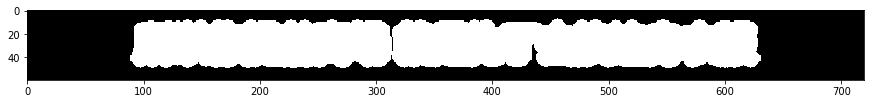

In [40]:
subtitle_stoke = cv2.dilate(result_mask,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(13,13))) 
plt.imshow(subtitle_stoke,cmap = plt.cm.gray)
plt.show()

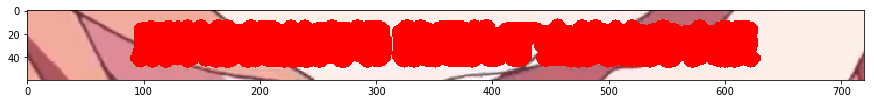

In [42]:
#ตัวอย่าง ผสานปภาพ
lay_img = subtitle_frame.copy()
for y in range(0,height):
    for x in range(0,width):
        if subtitle_stoke[y][x] == 1:
            lay_img[y][x][0] = 255
            lay_img[y][x][1] = 0
            lay_img[y][x][2] = 0
plt.imshow(lay_img)
plt.show()

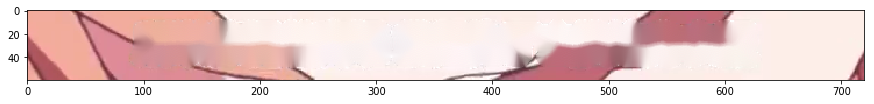

In [41]:
tofix_image = subtitle_frame.copy()
fixed_image = cv2.inpaint(tofix_image,subtitle_stoke,5,cv2.INPAINT_TELEA)
plt.imshow(fixed_image)
plt.show()